# U-Netとは

### 1. 基礎理論：CNNからFCNへ  
従来の画像分類（CNN）から、ピクセルごとの領域分割（セグメンテーション）を行うFCNへの進化について。  

**従来のCNN（画像分類）**  
- 構造：畳み込み層で特徴抽出後、全結合層で情報を「1次元」に潰して混ぜ合わせる。  
- 出力：「これは猫である」という**ラベル（What）**のみ。位置情報は失われる。  
- 制約：入力画像のサイズが固定されている必要がある。  

**FCN（完全畳み込みネットワーク）**  
- 構造：全結合層を廃止し、すべて畳み込み層（1×1 convなど）で構成。  
- 出力：ヒートマップ（確率分布図）。位置情報を保ったまま、ピクセル単位で「どこに何があるか（Where）」を出力する。  
- 利点：どんなサイズの画像でも入力可能。  

### 2. U-Netの構造：特徴抽出と復元  
FCNをベースに、情報の「圧縮」と「復元」をU字型に行うアーキテクチャ。  

**左側：収縮パス（エンコーダ）**  
- 役割：画像の特徴（意味）を抽出する。ResNetなどの学習済みモデル（バックボーン）を使うこともある。  
- 処理：畳み込みとプーリングを繰り返し、画像サイズを小さくしながらチャネル数（情報の深さ）を増やす。  
- 効果：位置情報は曖昧になるが、画像の「大まかな意味（コンテキスト）」や抽象的な特徴を学習する。計算コスト削減や過学習防止の効果もある。  

**底：ボトルネック**  
画像サイズは最小、チャネル数は最大。最も抽象化された情報が集まる場所。  

**右側：拡張パス（デコーダ）**  
- 役割：画像の解像度を元に戻し、ピクセル単位の予測を行う。  
- 処理：**アップサンプリング（転置畳み込み等）**を用いて、小さくなった特徴マップを引き延ばし、解像度を上げる。  
- 転置畳み込み：単なるコピー拡大（Nearest Neighbor）ではなく、重みを学習しながら形を復元する手法。  

### 3. U-Netの核心技術：スキップ接続（Skip Connection）  
単に画像を拡大するだけでは失われた「精細な情報」を補うための仕組み。  
- 課題：プーリングで画像が小さくなると、元の位置情報や輪郭が失われ、拡大してもボケてしまう。  
- 解決策：エンコーダ（左側）の同じ高さにある層の特徴マップを、デコーダ（右側）へ直接コピーして結合（Concatenate）する。  
- 効果：左側の「位置情報・細かい輪郭」と、右側の「意味情報」を組み合わせることで、境界線がくっきりとした高精度なセグメンテーションが可能になる。  

### 4. 画像処理の戦略（大きな画像への対応）  
巨大な画像を扱う際や、画像の端（境界）での精度低下を防ぐ工夫。  

**タイリングとオーバーラップ**  
画像をタイル状に分割して処理する際、端の情報不足を防ぐために、入力画像を少し重ねて（オーバーラップさせて）読み込む戦略。  

**ミラーリング**  
画像の端の外側に、反転させた画像を仮想的に配置（外挿）するパディング手法。ゼロ埋め（黒塗り）するよりも、文脈が途切れず精度が落ちにくい。  

### 5. 学習と損失関数  
モデルを正しく賢くするための評価方法。  

**重み付き損失（Weighted Loss）**  
- 目的：細胞同士の接触面など、分離が難しい境界線を正しく認識させるため。  
- 仕組み：境界部分や間違いやすい箇所のピクセルに対して「損失（ペナルティ）」を大きく設定する。これにより、モデルはその部分を必死に学習し、物体ごとの分離性能が向上する。  

**マスク画像**  
正解データ（Ground Truth）。対象物が1、背景が0（またはクラスごとに色分け）となる画像。モデルはこのマスクと同じものを出力するように重みを修正していく。  
教師なし/異常検知（応用）  
正解マスクがない場合でも、正常な画像をそのまま再現するように学習させ、再現できなかった部分を「異常」とみなす手法もある。  

一言まとめ：  
    U-Netは、FCNの考え方をベースに、画像を小さくして意味を理解する「エンコーダ」と、スキップ接続で位置情報を補いながら元に戻す「デコーダ」を組み合わせることで、**「何が（意味）」だけでなく「どこに（位置）」**あるかを精密に予測（セグメンテーション）できるモデルです。  

In [1]:
from PIL import Image

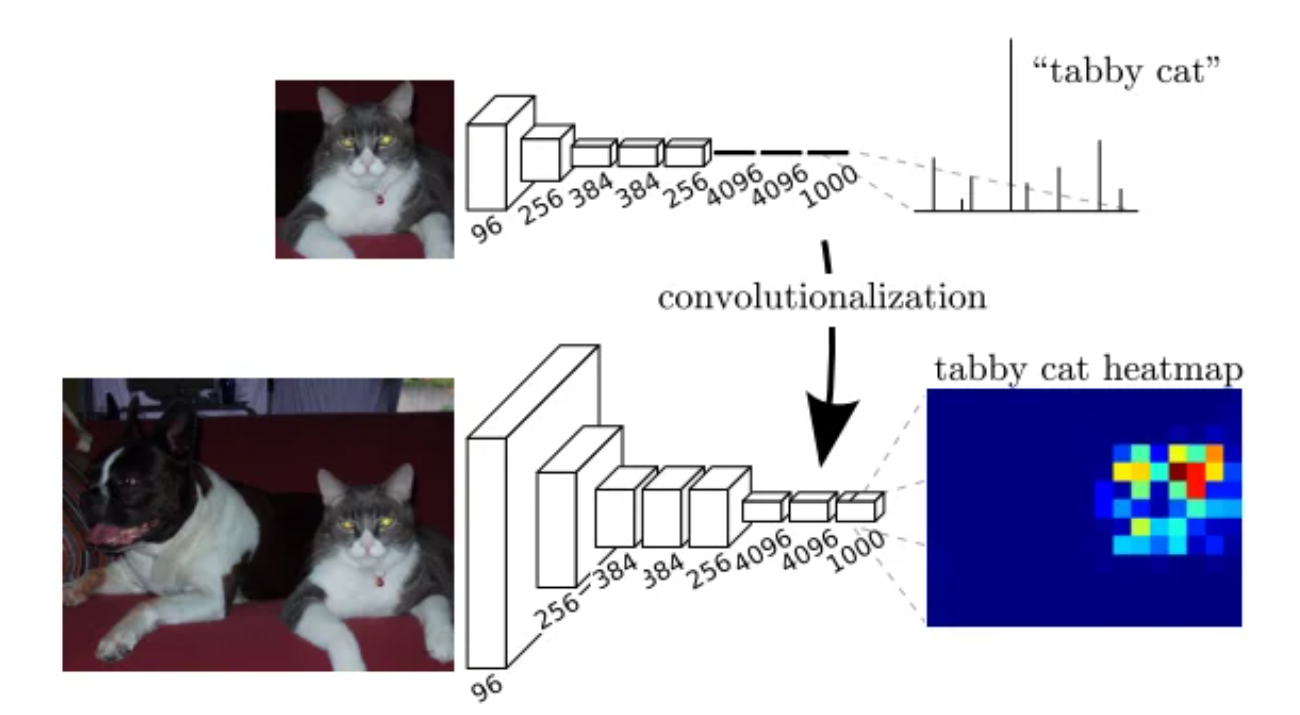

In [4]:
data = './data/fcn.png'
img = Image.open(data)
img

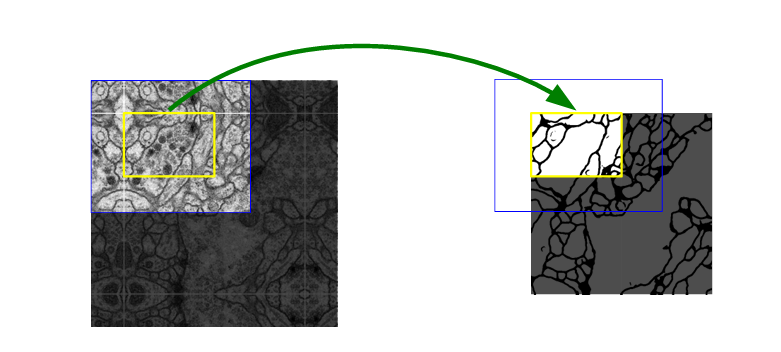

In [5]:
data = './data/pooling.png'
img = Image.open(data)
img

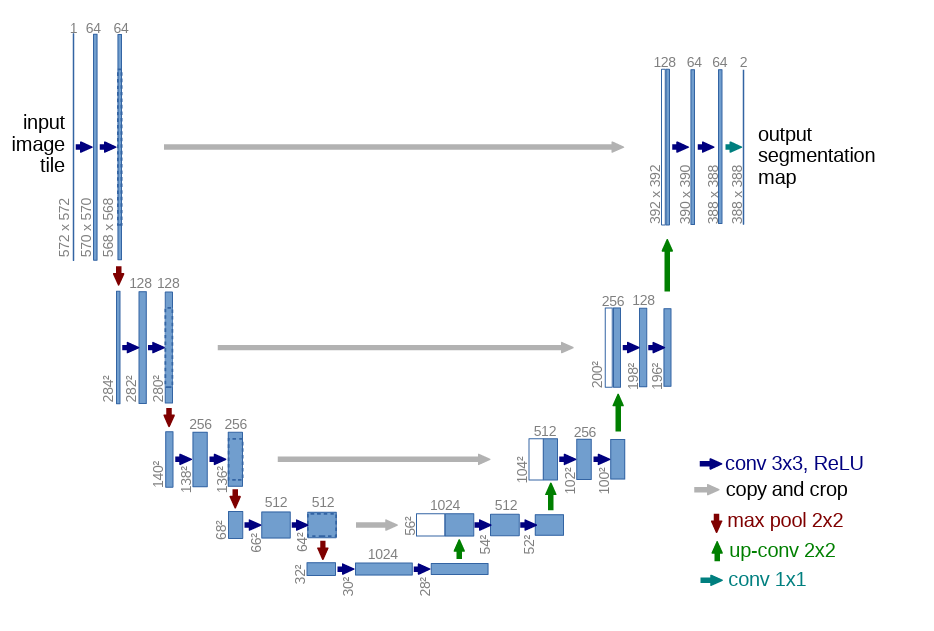

In [6]:
data = './data/unet.png'
img = Image.open(data)
img

### 元メモ

知らない単語
・完全畳み込みネットワーク
従来のCNN:[畳み込み層] → [畳み込み層] → [全結合層] 「これは猫である」というラベルを出力
FCN:[畳み込み層] → [畳み込み層] → [畳み込み層] 「ピクセルごとの分類地図（マップ）」を出力
①全結合層を「1×1 畳み込み」に置き換え
どんなサイズの画像でも入力可能
②アップサンプリング（反復転置畳み込み）
エンコード過程で小さくなったデータを、元の画像と同じサイズまで引き延ばす処理（DeconvolutionやTransposed Convolutionなど）を含みます。これにより、画像上の「どこ」が何かを特定できます。
③ ピクセル単位の予測
出力は単一の数値ではなく、入力画像と同じ縦横サイズを持つヒートマップのような形式になります。

・収縮ネットワーク
プーリングすることにより画像の小さくし、情報の密度を高めること。うまくいくのか？
・補完
これでは、画像の中に何があるか分かっても、どのピクセルがそれにあたるか分からない。小さくなったデータを大きくする層をたして、補完する。
・アップサンプリング
プーリングは2*2のエリアから1つを選んでサイズを小さくする。アップは1ピクセルを2*2に戻すようなこと
手法
Nearest Neighbor / Bilinear　周りの色をコピーして広げる
転置畳み込み (Transposed Conv)は重みを使って広げる。解像度を上げながら形を復元？？
これにより、画像がもとのサイズに戻ってくれる。
転置→行列を転置して計算するから
・スキップ接続
情報をショートカットさせる道？
データを層を通さずに先の層に直接届けることができる
縮小されたデータを拡大するだけでは、元の形を思い出せず、ぼけてしまうことも。ここで、元のデータを渡すことで細かい輪郭の復元に用いる。
チャネル数が増やす。色の深さのようなものを増やすことで、より意味を学習させる。チャネルがその位置の意味を保持している。このチャネルを用いて、u時の底（低画像度の層）がもつ抽象化された画像（おおまかな画像がもつ意味）をu字の上、高解像度の層へと伝播させられる。
U-netのUは、ほぼ対象であることも示しており、縮小した分、拡大することをしめす。
（
縮小させる意図は、画像全体が何を示しているかを分かるようにするため。
画像内の対象物が少しずれただけで別のものと判定しないよう、大まかなに認識してもらうため
計算コスト削減、過学習防止
）
・ミラーリング
画像の外側に、反対側の絵をコピーして貼り付ける。外挿。パディングを行い、周囲の画像の情報を0にしていくと、外側の情報が存在せず精度が低下する。
・タイリング
画像をタイル状に分け、重なりをもたせて少しづつ処理し、最後にパズルを完成させる手法。1ピクセルごとに行うよりも処理速度向上
・オーバーラップ戦略
画像をタイルに分割してそれぞれをオーバーラップさせる。周囲情報を補完し、サイズを大きくする。
Unetはパディングを行わない。
画像を分割し、タイルとした時、畳み込みを行うにつれ小さくなる。これではタイルとタイルの間に隙間が生まれる。端の予測ができない。これをオーバーラップで解決したい。オーバーラップというのは入力をだぶらせて読み込めば、縮小しても大丈夫という流れ。
重なり部分をヒント（コンテキスト）として畳込む。
u-netは画像の意味ある特徴を抽出し（底方向）、ピクセル単位の予測に変換する（上方向）。
畳込
・U字の左上、収縮パス
まだ抽象化できておらず、細かい部分の特徴をみている。また、この結果は位置情報としてスキップ接続により後半の復元に用いられる。
・底　ボトルネック層
プーリングを繰り返したことにより画像サイズは最小。チャネル（特徴を示す）の数は最大。
・右上　拡張パス
転置畳み込みで大きくした画像と、位置情報を持つ元の画像を組み合わせ、その画像の持つ意味と位置がある画像となる。
u-netが出力する画像はマスク画像
各ピクセルに対して意味のある部分を1, それ以外を0というようなマスクになる。この場合は白黒。多クラスなら色分けされる。どこに何があるかを教えてくれる。
・学習
画像と正解のマスクから、予測と評価、重みの修正を行う。その重みを用いて推論を行う。
（
「学習データと答え（マスク）」のペアがない場合でも、U-Netの重みを学習させる手法が存在します。
例: 異常検知。正常な画像だけをU-Netに入力し、「入力をそのまま出力として再現する」ように学習させます。未知の「異常な画像」が入ってきたとき、重みが対応できずに出力がバグることを利用して、異常箇所を特定します。ここでは「答えの塗り絵」を用意しません。
）
重み付き損失
指定箇所での間違いの損失を大きくする。
接触しているオブジェクト（細胞の重なりなど）を一つとして認識するのではなく、2つと分離させたい。接触している部分のラベルに大きな重みを与えることで、これを可能にした。
エンコーダ
入力された画像を畳み込み、特徴を抽出する。resnetや学習されたモデルを利用する（backbone）ことで精度を上げることができる
デコーダ
逆畳み込み、特徴マップを大きくする。
この時、特徴マップを複製し切り出しを行うことで、連結する。スキップ接続により位置を知れる。u-netの特徴
セグメンテーション
画像内のピクセルが何に属するか分類し色分けすること。
CNNによりflattenを行うと位置情報をなくして画像の情報を捉える。これは何であるかを示す。
ここで、全結合層を畳み込み層に変えると各ピクセルか小さい領域が何であるのかを知れる。これにより、ある程度配置を保ったまま画像に認識ができる。
これは、画像に対してフィルターをあてることで、その部分が対象の物体であるかどうかがわかる。
これがfcn。
けど、これを何度も繰り返すと、プーリングの影響で物体の位置の情報は失われていく。これを、スキップ接続で改善していく。
fully convolution network
deconvolution
skip-connection
を用いているのがu-net
